In [41]:

# 🔁 Imports - run this first cell
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

print("Libraries loaded. Runtime OK.")


Libraries loaded. Runtime OK.


In [42]:

# 📥 Load dataset
# Priority: use 'train.csv' if present (Kaggle Titanic). Otherwise fallback to seaborn's titanic dataset.
if os.path.exists('train.csv'):
    df = pd.read_csv('train.csv')
    print("Loaded train.csv from current directory (Kaggle format).")
else:
    df = sns.load_dataset('titanic')
    # seaborn titanic has slightly different column names and contains NaNs in 'age' etc.
    # Normalize seaborn dataset to Kaggle-like columns used by this notebook where possible.
    df = df.rename(columns={
        'class': 'Pclass', 'sex': 'Sex', 'survived': 'Survived', 'sibsp': 'SibSp',
        'parch': 'Parch', 'fare': 'Fare', 'embarked': 'Embarked', 'age': 'Age', 'who':'Who'
    })
    # seaborn's 'Pclass' is categorical; convert to int if possible
    try:
        df['Pclass'] = df['Pclass'].astype(int)
    except:
        pass
    print("No train.csv found — using seaborn's Titanic dataset (compatible fallback).")

df.head()


Loaded train.csv from current directory (Kaggle format).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:

# 🔎 Quick preview & info
print('Rows, Columns:', df.shape)
print('\nColumn names:', df.columns.tolist())
df.info()


Rows, Columns: (891, 12)

Column names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [44]:

# 🧹 Basic cleaning decisions used in internship submission
# - Fill Age with median
# - Fill Embarked with mode (if present)
# - Drop Cabin (too many missing) if present
# - Convert Sex to numeric, create Embarked dummies if present
df_clean = df.copy()

# If Kaggle train.csv style (has 'Cabin' etc.), handle accordingly
if 'Cabin' in df_clean.columns:
    df_clean.drop(columns=['Cabin'], inplace=True)

if 'Age' in df_clean.columns:
    df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())

if 'Embarked' in df_clean.columns:
    df_clean['Embarked'] = df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0])

# Sex handling
if 'Sex' in df_clean.columns:
    df_clean['Sex'] = df_clean['Sex'].map({'male':0, 'female':1})

# If Embarked exists, create dummies
if 'Embarked' in df_clean.columns:
    embarked_dummies = pd.get_dummies(df_clean['Embarked'], prefix='Embarked', drop_first=True)
    df_clean = pd.concat([df_clean, embarked_dummies], axis=1)
    # keep only original columns we will use later
df_clean.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,False,False
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,False,True
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,False,True


In [45]:

# 🔧 Feature selection
# We'll use these columns when available: Pclass, Sex, Age, SibSp, Parch, Fare
features = []
for col in ['Pclass','Sex','Age','SibSp','Parch','Fare']:
    if col in df_clean.columns:
        features.append(col)

X = df_clean[features].copy()
y = None
if 'Survived' in df_clean.columns:
    y = df_clean['Survived'].copy()
else:
    # seaborn has 'survived' already mapped; try alternate names
    if 'survived' in df_clean.columns:
        y = df_clean['survived'].copy()
    else:
        # If no label available (unlikely), raise an informative error
        raise ValueError("No survival label found in dataset. Make sure 'Survived' column exists (Kaggle) or use Kaggle train.csv.")

print('Features used:', features)
X.head()


Features used: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,3,1,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,3,0,35.0,0,0,8.0500


In [46]:

# 🔢 Preparation: scaling and train-test split
# Fill any remaining nulls with median (safety)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)


Train/Test shapes: (712, 6) (179, 6)


In [47]:

# 🧠 Train Logistic Regression
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [48]:

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {acc:.4f}\n')
print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(report)


Accuracy: 0.7989

Confusion Matrix:
[[90 15]
 [21 53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



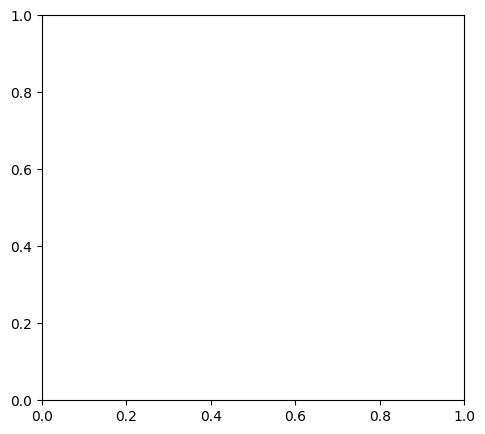

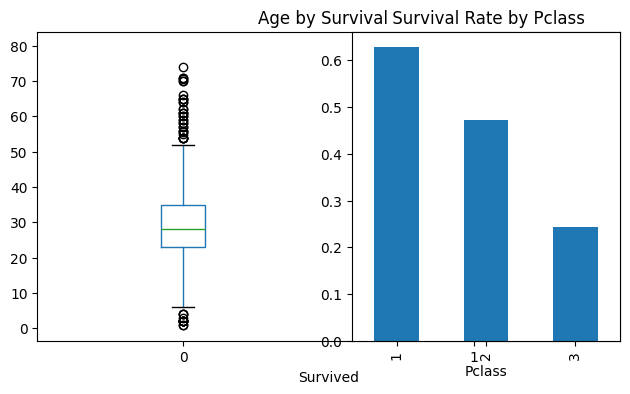

In [49]:

# 📊 Simple visualization: Age distribution by survival & survival by Pclass
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
if 'Age' in df_clean.columns:
    df_clean.boxplot(column='Age', by='Survived', grid=False)
    plt.title('Age by Survival  ')
    plt.suptitle('')
else:
    plt.text(0.1, 0.5, 'Age not available', fontsize=12)

plt.subplot(1,2,2)
if 'Pclass' in df_clean.columns:
    df_clean['Pclass'] = df_clean['Pclass'].astype(int)
    df_clean.groupby('Pclass')['Survived'].mean().plot(kind='bar')
    plt.title(' Survival Rate by Pclass')
else:
    plt.text(0.1, 0.5, 'Pclass not available', fontsize=12)

plt.tight_layout()
plt.show()


In [50]:

# 💾 Save model and scaler for reuse (optional)
import joblib
joblib.dump(model, 'titanic_logreg_model.joblib')
joblib.dump(scaler, 'titanic_scaler.joblib')
print('Saved model -> titanic_logreg_model.joblib and scaler -> titanic_scaler.joblib')


Saved model -> titanic_logreg_model.joblib and scaler -> titanic_scaler.joblib
